<a href="https://colab.research.google.com/github/asepmuhidin/MK-Data-Mining-UPB/blob/main/tsa_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis Dekomposisi Time Series Harga Saham BBCA *(Additive, Multiplicative & STL Decomposition)*
### Created by Asep Muhidin
### Penelitian Hibah BIMA 2026
*"Pengembangan Model Hybrid Fuzzy–Deep Learning untuk Prediksi Harga Saham BCA dengan Pendekatan Explainable AI Berbasis SHAP dan LIME"*

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('mnt')

path='mnt/MyDrive/proposal bima xai/TimeSeries/'
df=pd.read_csv(f'{path}dataset/bbca_close_2015-2025.csv')
display(df)
print(df.info())

Drive already mounted at mnt; to attempt to forcibly remount, call drive.mount("mnt", force_remount=True).


,Date,Close
0,2015-01-02,2156.950684
1,2015-01-05,2152.873779
2,2015-01-06,2136.563965
3,2015-01-07,2140.641113
4,2015-01-08,2116.177002
...,...,...
2707,2025-12-23,8025.000000
2708,2025-12-24,8025.000000
2709,2025-12-26,8025.000000
2710,2025-12-29,8025.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2712 entries, 0 to 2711
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2712 non-null   object 
 1   Close   2712 non-null   float64
dtypes: float64(1), object(1)
memory usage: 42.5+ KB
None


In [74]:
df.set_index('Date', inplace=True)
df.index=pd.to_datetime(df.index)
df.head()

,Close
Date,
2015-01-02,2156.950684
2015-01-05,2152.873779
2015-01-06,2136.563965
2015-01-07,2140.641113
2015-01-08,2116.177002


## Additive & Multiplicative

In [75]:
!pip install statsmodels --quiet

In [76]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [86]:
series=df.Close
decomp_add=seasonal_decompose(series,period=30)
season_add=decomp_add.seasonal
trend_add=decomp_add.trend
residu_add=decomp_add.resid
observer_add=decomp_add.observed

In [78]:
import seaborn as sn
import matplotlib.ticker as mticker

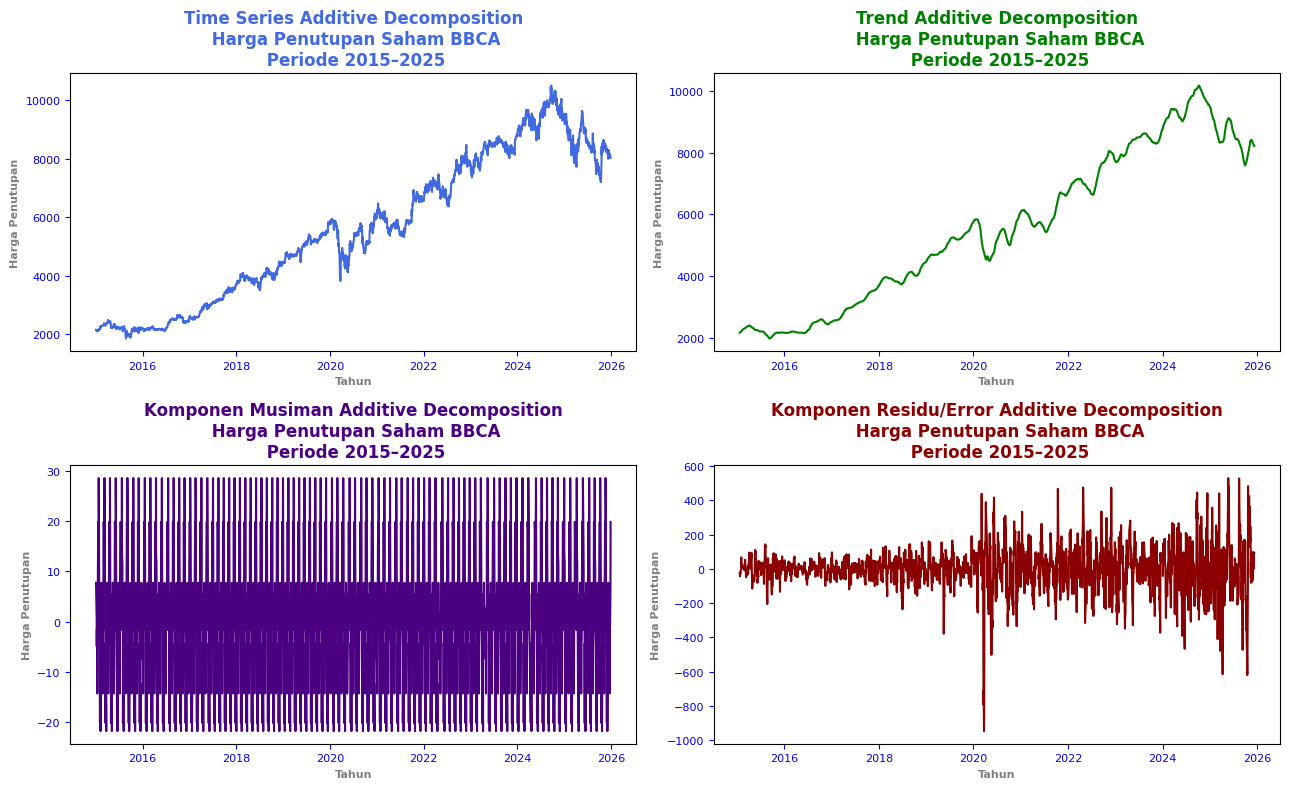

In [87]:
fig, axs=plt.subplots(2,2, figsize=(13,8))

title="Additive Decomposition\n Harga Penutupan Saham BBCA\n Periode 2015–2025"
set_title={'Time Series':{'color':'royalblue','data':series},
           'Trend':{'color':'green','data':trend_add},
           'Komponen Musiman':{'color':'indigo','data':season_add},
           'Komponen Residu/Error':{'color':'darkred','data':residu_add}
          }
z=zip(axs.flatten(),set_title.items())

for ax,(t,val) in z:
  ax.set_xlabel('Tahun', fontsize=8, fontweight='bold',color='grey')
  ax.set_ylabel('Harga Penutupan', fontsize=8, fontweight='bold',color='grey' )
  ax.tick_params(axis='y', labelsize=8, colors='blue',grid_color='grey', grid_alpha=0.2 )
  ax.tick_params(axis='x', labelsize=8, colors='blue',grid_color='b', grid_alpha=0.2 )
  ax.set_title(f"{t} {title}",fontdict={'fontsize':12, 'fontweight':'bold', 'color':val['color']})
  ax.plot(val['data'], color=val['color'])


plt.tight_layout()
plt.show()


“Berdasarkan hasil dekomposisi time series dengan periode 30, harga saham BBCA menunjukkan dominasi komponen tren jangka panjang, sementara pola musiman relatif lemah dan stabil. Variabilitas residual meningkat secara signifikan pada periode pasca-2020, yang mengindikasikan dinamika pasar yang lebih volatil dan kompleks.”

## Strength of Trend (TB) & Strenght of Seasonal (SB)

Pada dekomposisi time series aditif, data observasi dinyatakan sebagai:

$$
Y_t = T_t + S_t + R_t
$$

dengan:
- $Y_t$ : nilai observasi (harga penutupan)
- $T_t$ : komponen tren
- $S_t$ : komponen musiman
- $R_t$ : komponen residual

### Rumus Strength of Trend

Strength of Trend (TB) didefinisikan sebagai:

$$
\boxed{
TB = 1 - \frac{\operatorname{Var}(R_t)}{\operatorname{Var}(T_t + R_t)}
}
$$

Strength of Sesional (SB) didefinisikan sebagai:

$$
\boxed{
SB = 1 - \frac{\operatorname{Var}(R_t)}{\operatorname{Var}(S_t + R_t)}
}
$$

di mana:
- $\operatorname{Var}(R_t)$ adalah varians komponen residual  
- $\operatorname{Var}(T_t + R_t)$ adalah varians gabungan komponen tren dan residual  
- $\operatorname{Var}(S_t + R_t)$ adalah varians gabungan komponen sesional dan residual  

### Interpretasi Nilai TB dan SB

- $TB \approx 0$ : tren lemah (data didominasi noise)  
- $TB \approx 1$ : tren sangat kuat (noise relatif kecil)  

Nilai TB berada pada rentang $[0, 1]$ dan digunakan untuk mengukur dominasi komponen tren dalam menjelaskan variasi data time series.


In [80]:
import numpy as np
def decom_tbsb(t,r,s):
  df_tb = pd.concat([t, r,s], axis=1)
  df_tb.columns = ['trend', 'resid','sesion']
  df_tb = df_tb.dropna()
  var_resid = np.var(df_tb['resid'], ddof=1)
  var_trend_resid = np.var(
    df_tb['trend'] + df_tb['resid'],
    ddof=1
  )
  var_sesion_resid=np.var(df_tb['sesion']+df_tb['resid'], ddof=1)
  TB = 1 - (var_resid / var_trend_resid)
  SB = 1 - (var_resid / var_sesion_resid)
  return TB,SB


In [93]:
tb_add,sb_add=decom_tbsb(trend_add,residu_add,season_add)
print(f"Strength of Trend : {tb_add:.5f}")
print(f"Strength of Trend : {sb_add:.5f}")

Strength of Trend : 0.99744
Strength of Trend : 0.00793


## STL(Sessional Trend with LOESS)
### LOESS (*Locally Estimated Scatterplot Smoothing*)

In [90]:
from statsmodels.tsa.seasonal import STL

stl=STL(series,period=30)
res = stl.fit()
season_stl=res.seasonal
trend_stl=res.trend
residu_stl=res.resid
observer_stl=res.observed

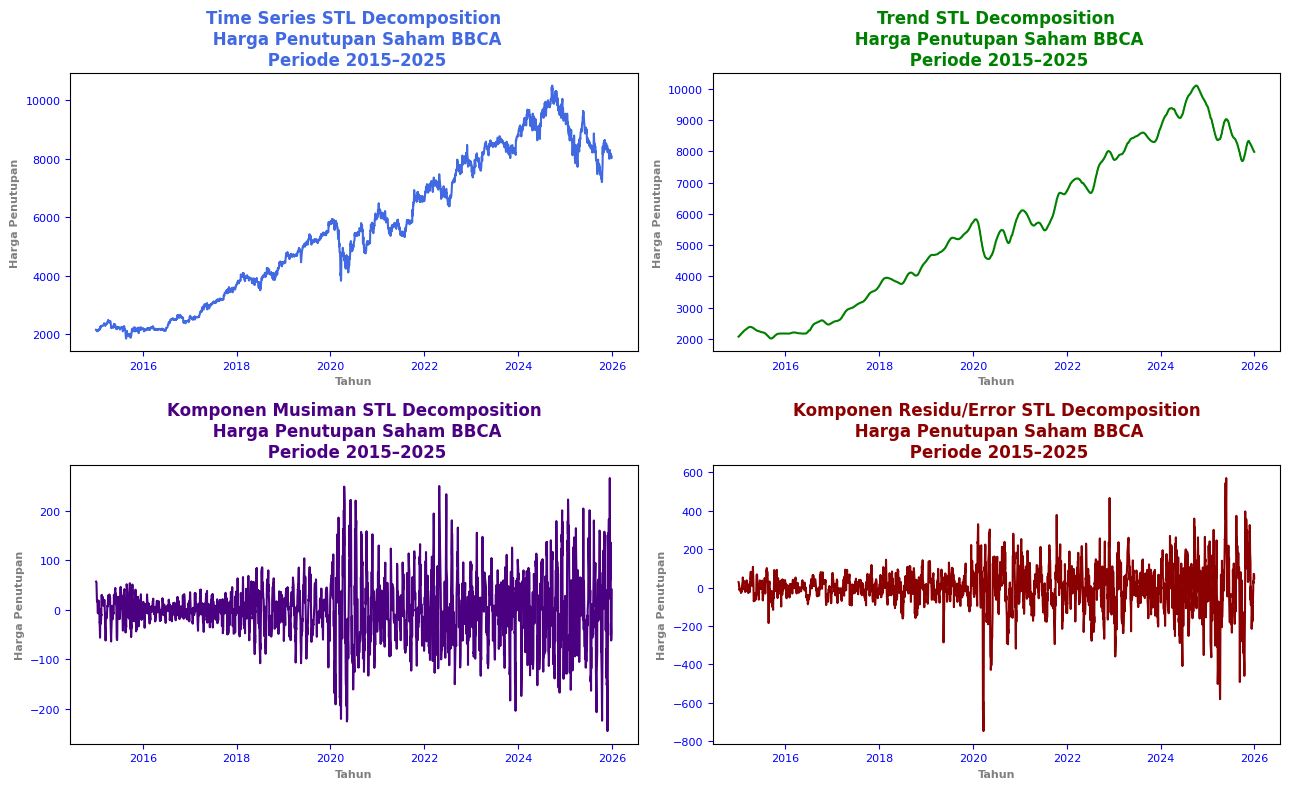

In [91]:
fig, axs=plt.subplots(2,2, figsize=(13,8))

title="STL Decomposition\n Harga Penutupan Saham BBCA\n Periode 2015–2025"
set_title={'Time Series':{'color':'royalblue','data':series},
           'Trend':{'color':'green','data':trend_stl},
           'Komponen Musiman':{'color':'indigo','data':season_stl},
           'Komponen Residu/Error':{'color':'darkred','data':residu_stl}
          }
z=zip(axs.flatten(),set_title.items())

for ax,(t,val) in z:
  ax.set_xlabel('Tahun', fontsize=8, fontweight='bold',color='grey')
  ax.set_ylabel('Harga Penutupan', fontsize=8, fontweight='bold',color='grey' )
  ax.tick_params(axis='y', labelsize=8, colors='blue',grid_color='grey', grid_alpha=0.2 )
  ax.tick_params(axis='x', labelsize=8, colors='blue',grid_color='b', grid_alpha=0.2 )
  ax.set_title(f"{t} {title}",fontdict={'fontsize':12, 'fontweight':'bold', 'color':val['color']})
  ax.plot(val['data'], color=val['color'])


plt.tight_layout()
plt.show()

In [94]:
tb_stl,sb_stl=decom_tbsb(trend_stl,residu_stl,season_stl)
print(f"Strength of Trend : {tb_stl:.5f}")
print(f"Strength of Trend : {sb_stl:.5f}")

Strength of Trend : 0.99806
Strength of Trend : 0.30880


In [95]:
model_decomp={'Additive':{'tb':tb_add,'sb':sb_add},'STL':{'tb':tb_stl,'sb':sb_stl}}
pd.DataFrame(model_decomp)

,Additive,STL
tb,0.997441,0.998064
sb,0.007933,0.308799
